In [19]:
import pickle

# Third-party
import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy.ndimage import gaussian_filter
import pystan

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.mpl_style import hesperia
from gala.units import galactic
from pyia import GaiaData

In [2]:
gd1 = GaiaData('/Users/adrian/projects/gd1-dr2/data/gd1-better-selection.fits')

In [3]:
phi1 = gd1.phi1.value
phi2 = gd1.phi2.value

To place the nodes, we use the ridgeline:

In [4]:
ridge = Table.read('../output/gd1_ridgeline.csv')

In [5]:
c = coord.SkyCoord(ridge['ra']*u.deg, ridge['dec']*u.deg).transform_to(gc.GD1)
phi_poly = np.poly1d(np.polyfit(c.phi1.wrap_at(180*u.deg).degree,
                                c.phi2.degree, 
                                deg=5))

In [36]:
(xbins, ybins, S) = np.load('../output/astrometric_selection_function_map.npy')
# S = S[60:100, 15:-5]
# xbins = xbins[60:100+1]
# ybins = ybins[15:-5]

phi1 spacing: 2.0, 61 nodes


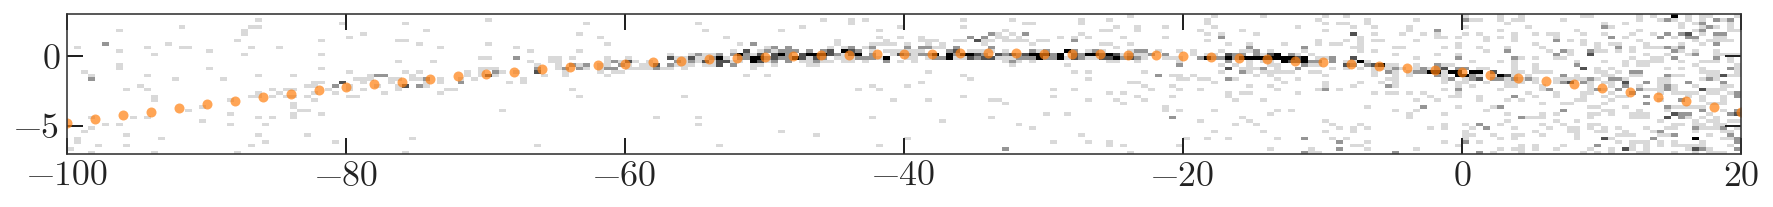

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

H, xe, ye = np.histogram2d(phi1, phi2, 
                           bins=(xbins, ybins))

# TODO: start with fake data:
# ntest = 8000
# xbins = np.arange(-60, -50+1e-3, 0.2)
# ybins = np.arange(-2, 2+1e-3, 0.2)
# _phi1 = np.random.uniform(-60, -40, size=ntest)
# _phi2 = np.random.normal(0, 0.25, size=ntest)
# H, xe, ye = np.histogram2d(_phi1, _phi2, 
#                            bins=(xbins, ybins))
# S = np.ones_like(H)
# S[10:15] = 0.2
# S[35:40] = 0.2
# H *= S

assert H.size == S.size

xe_c = 0.5 * (xe[:-1] + xe[1:])
ye_c = 0.5 * (ye[:-1] + ye[1:])

ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmin=0, vmax=4)

h_phi1 = 2
# phi1_nodes = np.linspace(-100, 20, 100)
phi1_nodes = np.arange(xe.min(), xe.max()+1e-3, h_phi1)
print('phi1 spacing: {}, {} nodes'.format(phi1_nodes[1]-phi1_nodes[0], len(phi1_nodes)))
phi2_nodes = phi_poly(phi1_nodes)
ax.plot(phi1_nodes, phi2_nodes, 
        marker='o', alpha=0.7, 
        ls='none', color='tab:orange')

ax.set_aspect('equal')

In [38]:
xx, yy = np.stack(list(map(np.ravel, np.meshgrid(xe_c, ye_c))))

In [39]:
data = {}
data['n_pix'] = H.size
data['hh'] = H.T.ravel().astype(np.int32)
data['S'] = S.T.ravel()
data['x'] = xx
data['y'] = yy

data['n_nodes'] = len(phi1_nodes)
data['phi1_nodes'] = phi1_nodes
data['phi2_nodes_init'] = phi2_nodes
data['h_nodes'] = np.full_like(phi1_nodes, 1. * h_phi1)

data['a1'] = xbins.min()
data['b1'] = xbins.max()
data['a2'] = ybins.min()
data['b2'] = ybins.max()

In [40]:
nchains = 1
init_dict = {}
init_dict['d_phi2_nodes'] = np.zeros(data['n_nodes'])
init_dict['log_w_nodes'] = np.full(data['n_nodes'], np.log(0.15))
init_dict['log_a_nodes'] = np.full(data['n_nodes'], np.log(10))
init_dict['log_c1'] = 0.
init_dict['log_c2'] = 0.
init_dict['log_c3'] = 0.
init_dict['x0'] = -50.
inits = [init_dict]

---

In [11]:
sm = pystan.StanModel('../stan/binned_model_apw.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc8ba413af8fbac52af95e6936fd28dd NOW.


In [ ]:
fit = sm.optimizing(data=data, init=inits[0], iter=100)

In [ ]:
# with open('binned_model_apw_fit.pkl', 'wb') as f:
#     pickle.dump(fit, f)

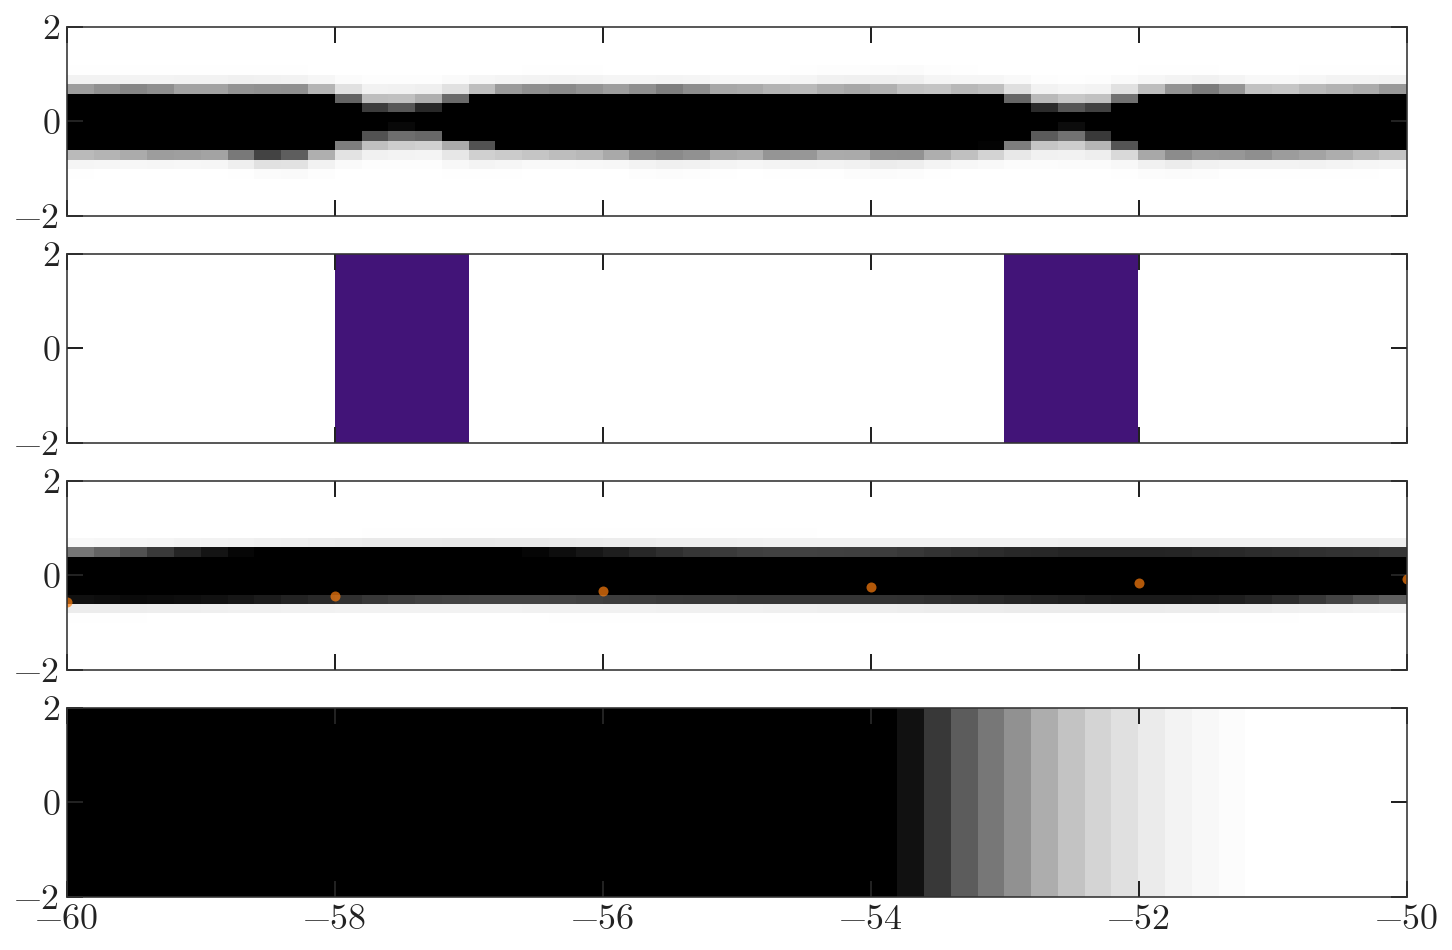

In [35]:
fig, axes = plt.subplots(4, 1, figsize=(12, 8),
                         sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(xe, ye, gaussian_filter(H.T, 1),
              cmap='Greys', vmin=1e-2, vmax=4)

ax = axes[1]
ax.pcolormesh(xe, ye, S.T,
              cmap='hesperia', vmin=0, vmax=1)

ax = axes[2]
ax.pcolormesh(xe, ye, np.exp(fit['log_gd1_int'].reshape(H.T.shape)),
              cmap='Greys', vmin=1e-2, vmax=4)
ax.plot(phi1_nodes, phi2_nodes, 
        marker='o', alpha=0.7, 
        ls='none', color='tab:orange')

ax = axes[3]
ax.pcolormesh(xe, ye, 
              np.exp(fit['log_bg_int'].reshape(H.T.shape)),
              cmap='Greys', vmin=1e-3, vmax=1e-2)

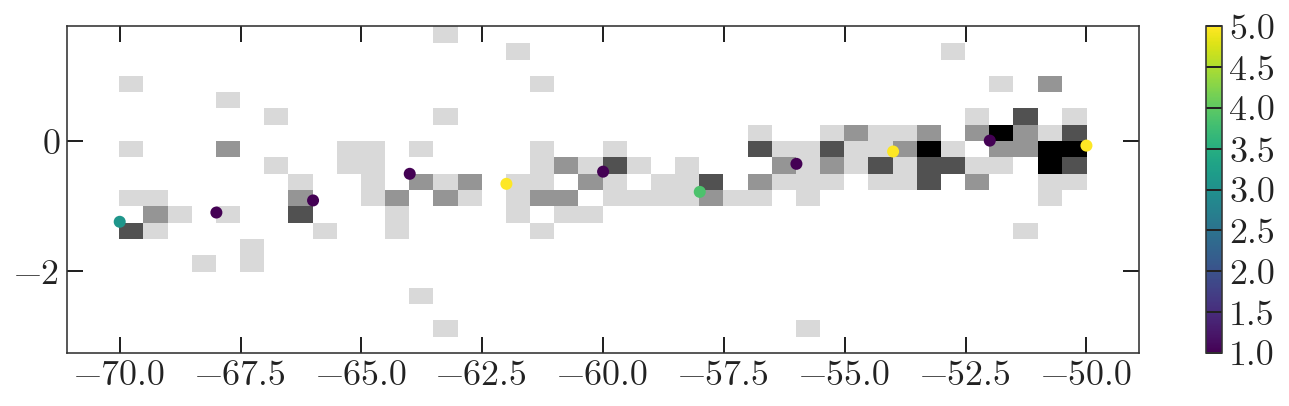

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmin=0, vmax=4)

im = ax.scatter(phi1_nodes, phi2_nodes + fit['d_phi2_nodes'],
                marker='o', 
                c=np.exp(fit['log_a_nodes']),
                vmin=1, vmax=5)

fig.colorbar(im)

In [55]:
# par_dict = init_dict
par_dict = fit

w_nodes = np.exp(par_dict['log_w_nodes'])
phi2_nodes = data['phi2_nodes_init'] + par_dict['d_phi2_nodes']
xmod = np.zeros(data['n_pix'])
xy = np.zeros(2)
node_xy = np.zeros(2)
tmp = np.zeros(data['n_nodes'])
for i in range(data['n_pix']):
    xy[0] = data['x'][i]
    xy[1] = data['y'][i]
    
    for j in range(data['n_nodes']):
        node_xy[0] = data['phi1_nodes'][j]
        node_xy[1] = phi2_nodes[j]
        
        tmp[j] = par_dict['log_a_nodes'][j] + multivariate_normal.logpdf(xy, mean=node_xy, 
                                                                         cov=get_cov(data['h_nodes'][j], w_nodes[j]))
    
    xmod[i] = logsumexp(tmp)

ERROR: NameError: name 'get_cov' is not defined [IPython.core.interactiveshell]
ERROR:astropy:NameError: name 'get_cov' is not defined


NameError: name 'get_cov' is not defined

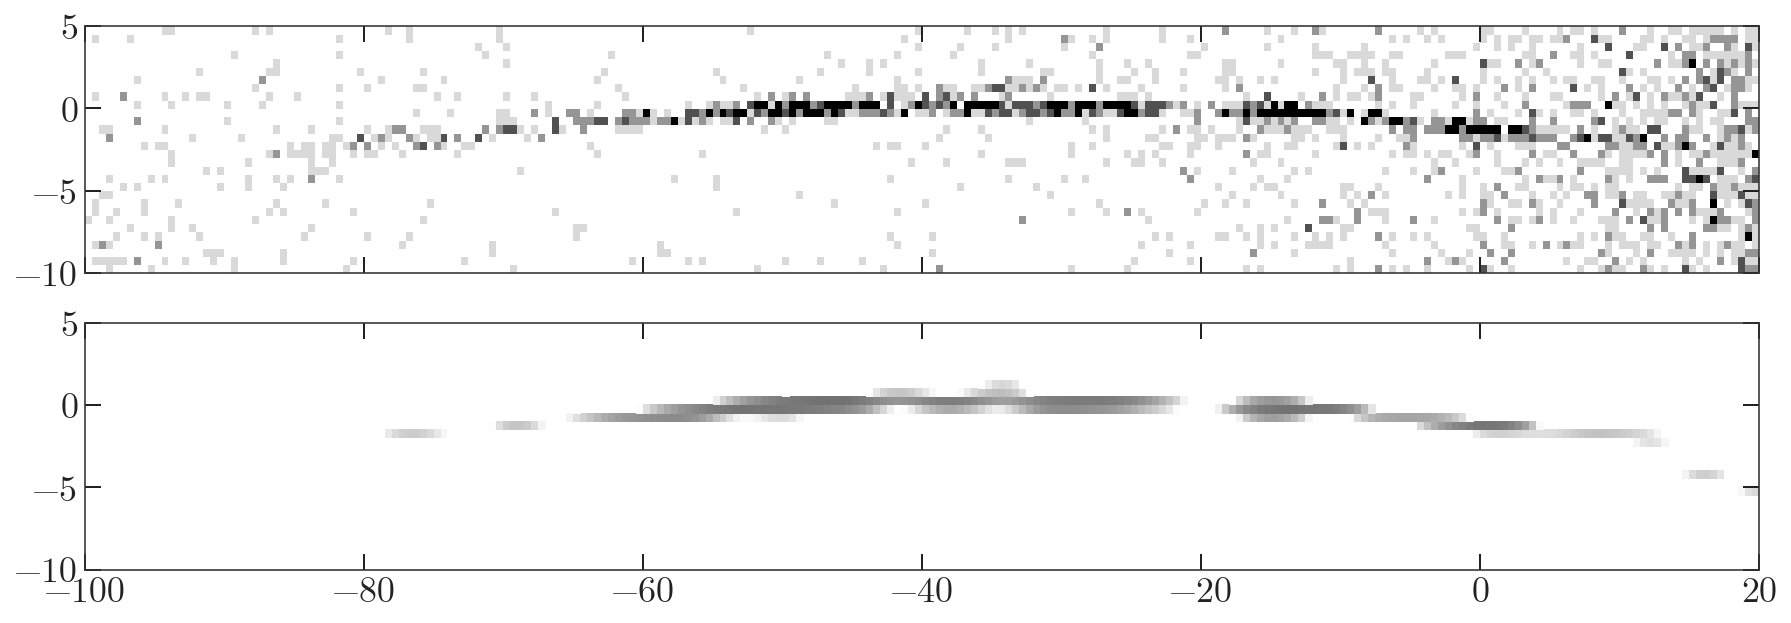

In [103]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

ax = axes[0]
ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmin=0, vmax=4)

ax = axes[1]
# ax.pcolormesh(xe, ye, xmod.reshape(H.T.shape), 
#               cmap='Greys', vmin=0, vmax=1)
ax.pcolormesh(xe, ye, xmod.reshape(H.T.shape), 
              cmap='Greys', 
              norm=mpl.colors.LogNorm(1e-1, 1e1))

In [ ]:
fit = sm.sampling(data=data, algorithm='NUTS', 
                  init=inits, 
                  iter=100, chains=nchains, n_jobs=1)

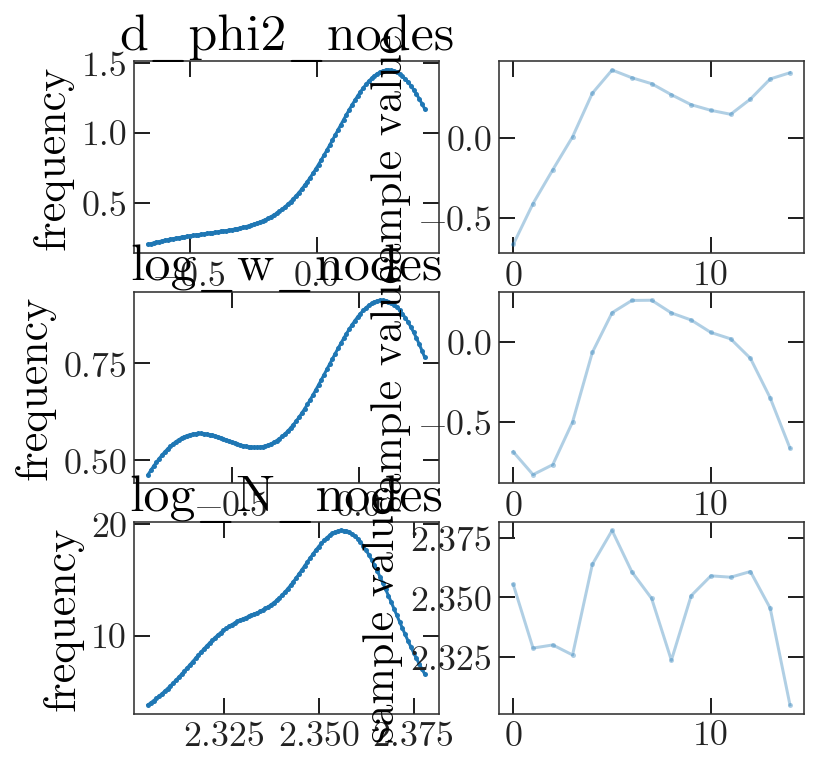

In [25]:
_ = fit.plot(pars=['d_phi2_nodes', 'log_w_nodes', 'log_N_nodes'])

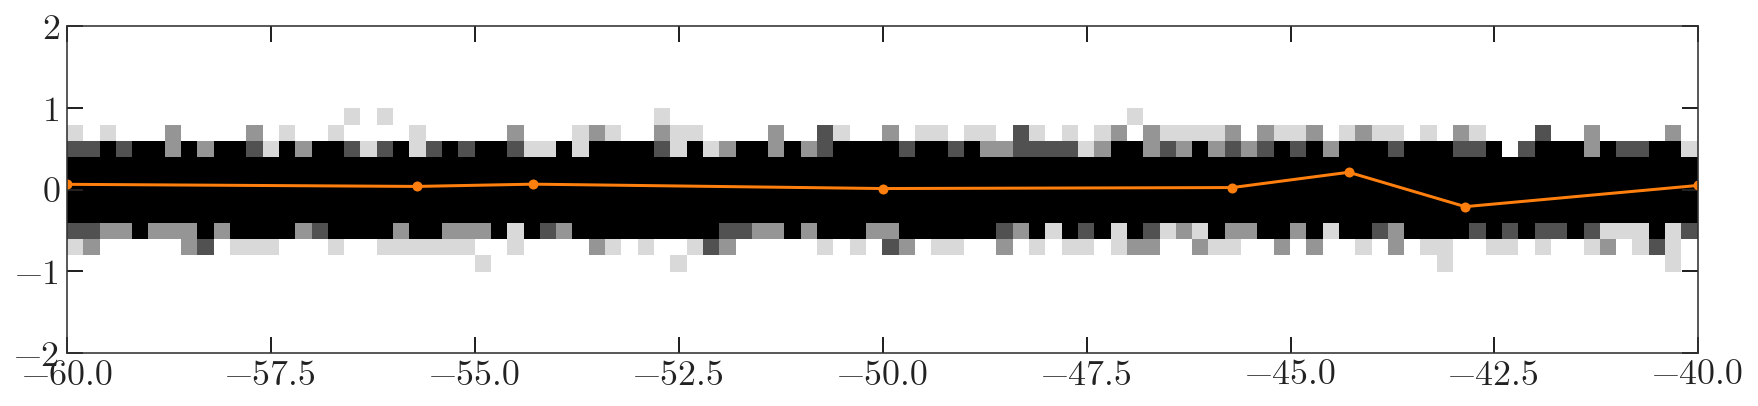

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmin=0, vmax=4)

# ax.plot(phi1_nodes, fit['phi2_nodes'][-1], 
ax.plot(phi1_nodes[np.exp(fit['log_N_nodes'])>20], 
        fit['phi2_nodes'][np.exp(fit['log_N_nodes']) > 20], 
        marker='o', color='tab:orange')

# ax.plot(phi1_nodes, phi2_nodes, 
#         marker='o', alpha=0.7, 
#         ls='none', color='tab:orange')

ax.set_aspect('equal')

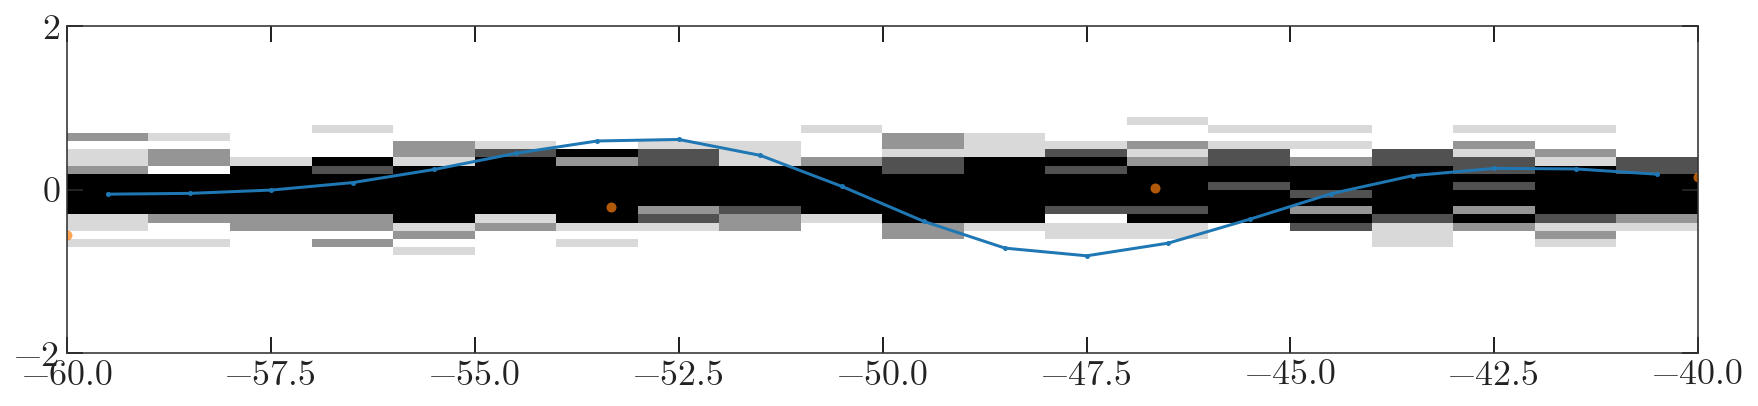

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmin=0, vmax=4)

ax.plot(xe_c, fit['fi2_val'][-1].reshape(H.T.shape)[0])

# phi1_nodes = np.linspace(-100, 20, 100)
phi1_nodes = np.linspace(-60, -40, 4)
phi2_nodes = phi_poly(phi1_nodes)
ax.plot(phi1_nodes, phi2_nodes, 
        marker='o', alpha=0.7, 
        ls='none', color='tab:orange')

ax.set_aspect('equal')

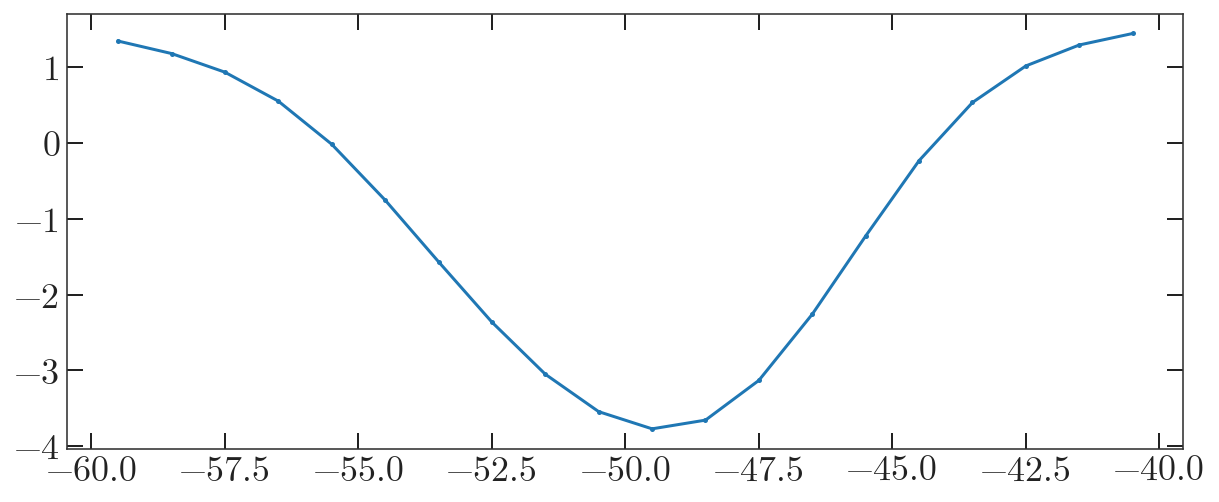

In [141]:
plt.figure(figsize=(10, 4))
plt.plot(xe_c, fit['logint_val'][-1].reshape(H.T.shape)[0])

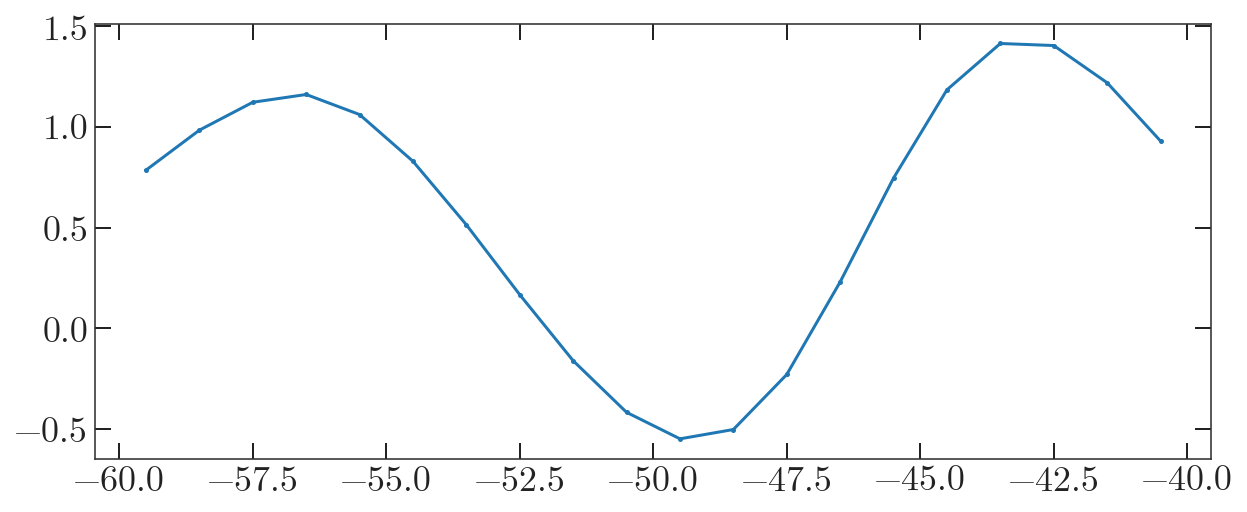

In [142]:
plt.figure(figsize=(10, 4))
plt.plot(xe_c, fit['logwidth_val'][-1].reshape(H.T.shape)[0])

In [ ]:
# with suppress_stdout_stderr():
#     fit = sm.sampling(data=data_dict, algorithm='HMC', iter=8192, init=init_dict, 
#                       chains=n_chains, n_jobs=1)

TEST STAN IDEA:

In [29]:
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

In [50]:
def get_cov(h, w):
    C = np.diag([h**2, w**2])
    return C

In [51]:
par_dict = init_dict
# par_dict = fit

w_nodes = np.exp(par_dict['log_w_nodes'])
phi2_nodes = data['phi2_nodes_init'] + par_dict['d_phi2_nodes']

xmod = np.zeros(data['n_pix'])
xy = np.zeros(2)
node_xy = np.zeros(2)
tmp = np.zeros(data['n_nodes'])
for i in range(data['n_pix']):
    xy[0] = data['x'][i]
    xy[1] = data['y'][i]
    
    for j in range(data['n_nodes']):
        node_xy[0] = data['phi1_nodes'][j]
        node_xy[1] = phi2_nodes[j]
        
        tmp[j] = par_dict['log_a_nodes'][j] + multivariate_normal.logpdf(xy, mean=node_xy, 
                                                                         cov=get_cov(data['h_nodes'][j], w_nodes[j]))
    
    xmod[i] = logsumexp(tmp)

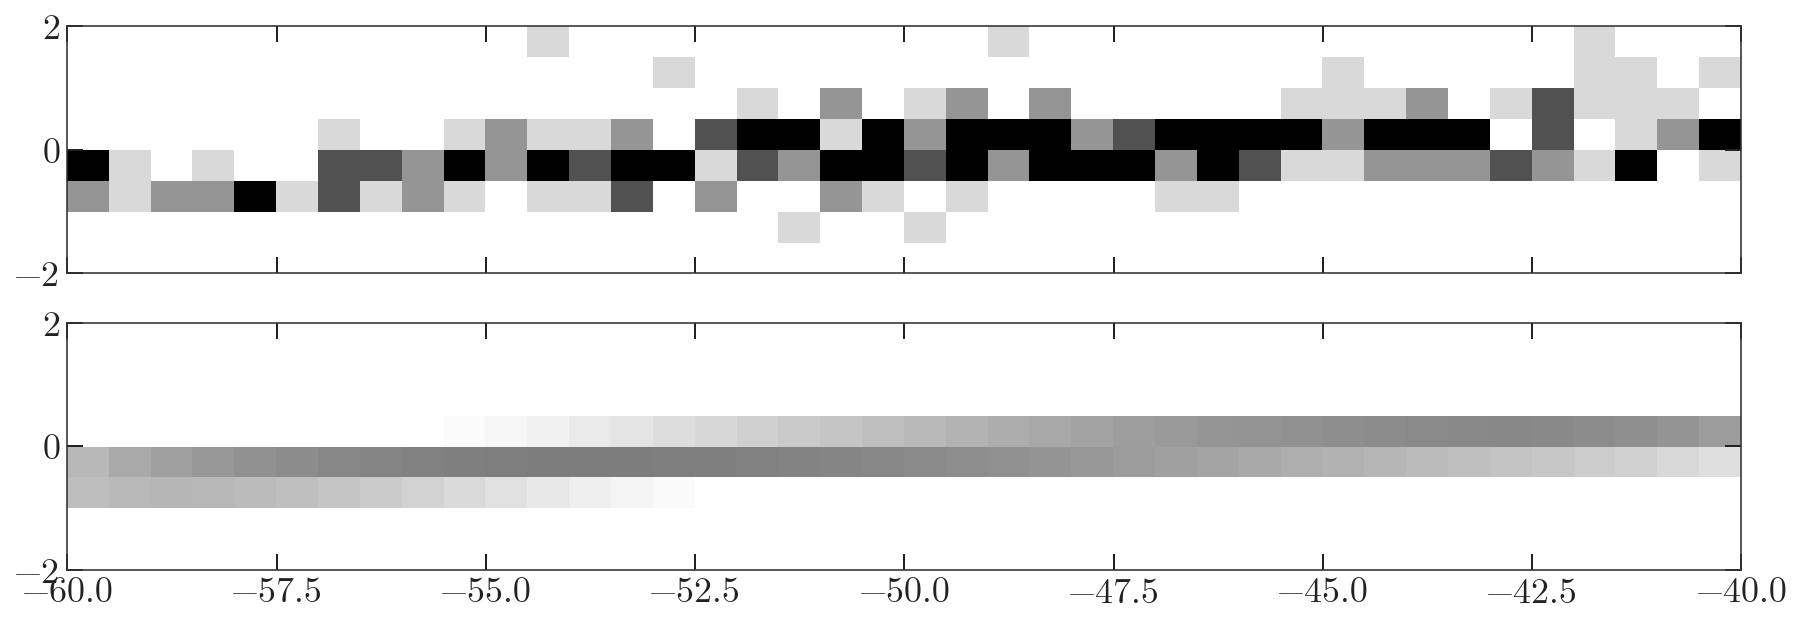

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

ax = axes[0]
ax.pcolormesh(xe, ye, H.T, 
              cmap='Greys', vmin=0, vmax=4)

ax = axes[1]
ax.pcolormesh(xe, ye, xmod.reshape(H.T.shape), 
              cmap='Greys', vmin=0, vmax=4)